# Interpreting models

This notebook offers interpretability tools from Captum to help visualize & understand what a model has learned. 
The tools include:
- Primary Attribution: Evaluates contribution of each input feature to the output of a model.
- Layer Attribution: Evaluates contribution of each neuron in a given layer to the output of the model.  

For code blocks containing Layer Attribution methods, you may indicate which layer you want to inspect with that method.

In [1]:
import os
import torch

# Make sure your cwd is the il-representations directory
if os.getcwd().split('/')[-1] == 'analysis':
    os.chdir("..")
print('Check cwd', os.getcwd())

Check cwd /Users/cynthiachen/Documents/Code/il-representations


In [2]:
from il_representations.scripts.interpret import (prepare_network, process_data, save_img, saliency_, deep_lift_, 
layer_conductance_, layer_gradcam_, layer_act_, choose_layer, interp_ex, get_venv)
from il_representations.envs.config import benchmark_ingredient
import il_representations.envs.auto as auto_env

import sacred
from sacred.observers import FileStorageObserver
from sacred import Experiment
from stable_baselines3.common.utils import get_device
from captum.attr import LayerActivation, LayerGradientXActivation

Loading chipmunk for Darwin (64bit) [/opt/anaconda3/envs/baselines/lib/python3.7/site-packages/pymunk/libchipmunk.dylib]


## Adjust config

In [3]:
render_interp_ex = Experiment('render_interp', ingredients=[benchmark_ingredient, interp_ex], interactive=True)
interp_ex.observers.append(FileStorageObserver('runs/interpret_runs'))

@interp_ex.config
def config():
    ##### These should be the only things you need to modify in this code block #####
    encoder_path = os.path.join(os.getcwd(), 'runs/downloads/ActionConditionedTemporalCPC/249_epochs.ckpt')
    assert os.path.isfile(encoder_path), f'Please double check if {encoder_path} exists.'
    
    
    # Data settings
    # The benchmark is set by detecting il_representations/envs/config's bench_defaults.benchmark_name
    imgs = [888]  # index of the image to be inspected (int)
    assert all(isinstance(im, int) for im in imgs), 'imgs list should contain integers only'

    verbose = False
    #################################################################################

## Initial set up

In [4]:
render_interp_ex = Experiment('render_interp', ingredients=[benchmark_ingredient, interp_ex], interactive=True)

@render_interp_ex.main
def run():
    venv = get_venv()
    network = prepare_network(venv)
    images, labels = process_data(venv)
    return network, images, labels

r = render_interp_ex.run()
network = r.result[0]
images = r.result[1]
labels = r.result[2]
verbose = True

WARNING - render_interp - No observers have been added to this run
INFO - render_interp - Running command 'run'
INFO - render_interp - Started


Loading benchmark dm_control...


INFO - render_interp - Result: (Network(
  (policy): ActorCriticCnnPolicy(
    (features_extractor): EncoderFeatureExtractor(
      (representation_encoder): DeterministicEncoder(
        (network): BasicCNN(
          (shared_network): Sequential(
            (0): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4))
            (1): ReLU()
            (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
            (3): ReLU()
            (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
            (5): ReLU()
            (6): Flatten()
            (7): Linear(in_features=5184, out_features=115, bias=True)
          )
        )
      )
    )
    (mlp_extractor): MlpExtractor(
      (shared_net): Sequential()
      (policy_net): Sequential()
      (value_net): Sequential()
    )
    (action_net): Linear(in_features=115, out_features=2, bias=True)
    (value_net): Linear(in_features=115, out_features=1, bias=True)
  )
), [tensor([[[[0.1451, 0.1451, 0.1490,  ..., 0.1490, 0.1451, 0.14

## Saliency

Saliency is a simple approach for computing input attribution, returning the gradient of the output with respect to the input. This approach can be understood as taking a first-order Taylor expansion of the network at the input, and the gradients are simply the coefficients of each feature in the linear representation of the model. The absolute value of these coefficients can be taken to represent feature importance.

/Users/cynthiachen/Documents/Code/il-representations/src/il_representations/algos/encoders.py:76: UserWarning: Input image tensor values have low stddev 0.0006293190526776016 (range [0.0005074971704743803, 0.003921568859368563]) (stack: runpy.py:193/runpy.py:85/ipykernel_launcher.py:16/application.py:664/kernelapp.py:612/asyncio.py:149/base_events.py:541/base_events.py:1786/events.py:88/ioloop.py:690/ioloop.py:743/gen.py:787/gen.py:748/kernelbase.py:365/gen.py:209/kernelbase.py:268/gen.py:209/kernelbase.py:545/gen.py:209/ipkernel.py:306/zmqshell.py:536/interactiveshell.py:2877/interactiveshell.py:2922/async_helpers.py:68/interactiveshell.py:3146/interactiveshell.py:3337/interactiveshell.py:3417/<ipython-input-5-f2d715900c42>:6/<ipython-input-5-f2d715900c42>:4/interpret.py:153/saliency.py:129/gradient.py:96/common.py:503/module.py:550/interpret.py:72/policies.py:511/policies.py:93/module.py:550/policy_interfacing.py:32/module.py:550/encoders.py:288/module.py:550/encoders.py:145/encoders

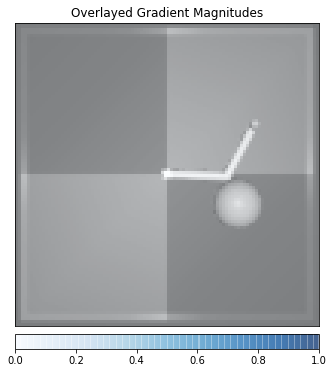

In [5]:
def saliency():
    for img, label in zip(images, labels):
        original_img = img[0].permute(1, 2, 0).detach().numpy()
        saliency_(network, img, label, original_img, None, False)

saliency()

## DeepLift
DeepLIFT is a back-propagation based approach that attributes a change to inputs based on the differences between the inputs and corresponding references (or baselines) for non-linear activations. As such, DeepLIFT seeks to explain the difference in the output from reference in terms of the difference in inputs from reference. DeepLIFT uses the concept of multipliers to "blame" specific neurons for the difference in output.

/opt/anaconda3/envs/baselines/lib/python3.7/site-packages/captum/attr/_core/deep_lift.py:301: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""
/Users/cynthiachen/Documents/Code/il-representations/src/il_representations/algos/encoders.py:76: UserWarning: Input image tensor values have low stddev 0.0008710578549653292 (range [0.0, 0.003921568859368563]) (stack: runpy.py:193/runpy.py:85/ipykernel_launcher.py:16/application.py:664/kernelapp.py:612/asyncio.py:149/base_events.py:541/base_events.py:1786/events.py:88/ioloop.py:690/ioloop.py:743/gen.py:787/gen.py:748/kernelbase.py:365/gen.py:209/kernelbase.py:268/gen.py:209/kernelbase.py:545/gen.py:209/ipkernel.py:306/zmqshell.py:536/interactiveshell.py:2877/interactiveshell.py:2922/async_helpers.py:68/interactiveshell.py:3146/interactiveshell.py:3337/interactiveshell.

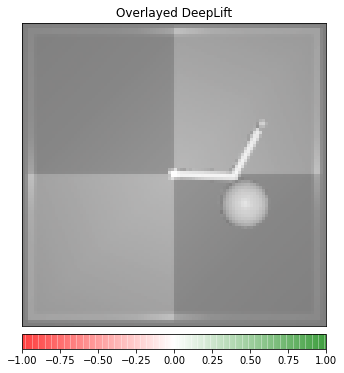

In [6]:
def deep_lift():
    for img, label in zip(images, labels):
        original_img = img[0].permute(1, 2, 0).detach().numpy()
        deep_lift_(network, img, label, original_img, None, False)

deep_lift()

## Layer GradCAM
GradCAM is a layer attribution method designed for convolutional neural networks, and is usually applied to the last convolutional layer. GradCAM computes the gradients of the target output with respect to the given layer, averages for each output channel (dimension 2 of output), and multiplies the average gradient for each channel by the layer activations. The results are summed over all channels and a ReLU is applied to the output, returning only non-negative attributions.

You have chosen Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1)) to show layer gradcam


/Users/cynthiachen/Documents/Code/il-representations/src/il_representations/algos/encoders.py:76: UserWarning: Input image tensor values have low stddev 0.0006293190526776016 (range [0.0005074971704743803, 0.003921568859368563]) (stack: runpy.py:193/runpy.py:85/ipykernel_launcher.py:16/application.py:664/kernelapp.py:612/asyncio.py:149/base_events.py:541/base_events.py:1786/events.py:88/ioloop.py:690/ioloop.py:743/gen.py:787/gen.py:748/kernelbase.py:365/gen.py:209/kernelbase.py:268/gen.py:209/kernelbase.py:545/gen.py:209/ipkernel.py:306/zmqshell.py:536/interactiveshell.py:2877/interactiveshell.py:2922/async_helpers.py:68/interactiveshell.py:3146/interactiveshell.py:3337/interactiveshell.py:3417/<ipython-input-7-f341ced78156>:15/<ipython-input-7-f341ced78156>:13/interpret.py:213/grad_cam.py:203/gradient.py:491/gradient.py:238/common.py:503/module.py:550/interpret.py:72/policies.py:511/policies.py:93/module.py:550/policy_interfacing.py:32/module.py:550/encoders.py:288/module.py:550/encod

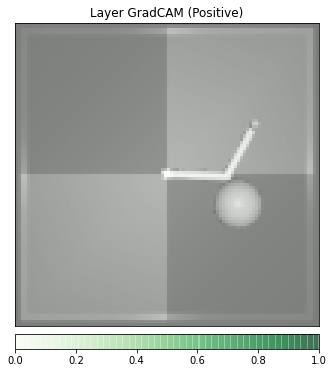

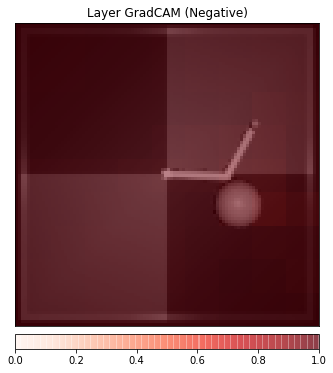

In [7]:
def layer_gradcam():
    for img, label in zip(images, labels):
        ##### These should be the only things you need to modify in this code block #####
        module = 'encoder'
        idx = 4
        #################################################################################
        chosen_layer = choose_layer(network, module, idx)
        original_img = img[0].permute(1, 2, 0).detach().numpy()
        assert isinstance(chosen_layer, torch.nn.Conv2d), 'GradCAM is usually applied to the last ' \
                                                          'convolutional layer in the network.'
        if verbose:
            print(f"You have chosen {chosen_layer} to show layer gradcam")
        layer_gradcam_(network, chosen_layer, img, label, original_img, None, False)

layer_gradcam()

## Layer Conductance
Conductance combines the neuron activation with the partial derivatives of both the neuron with respect to the input and the output with respect to the neuron to build a more complete picture of neuron importance.

You have chosen Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2)) to show layer conductance


/Users/cynthiachen/Documents/Code/il-representations/src/il_representations/algos/encoders.py:76: UserWarning: Input image tensor values have low stddev 0.0006536262226291001 (range [7.121719391989245e-08, 0.003921018447726965]) (stack: runpy.py:193/runpy.py:85/ipykernel_launcher.py:16/application.py:664/kernelapp.py:612/asyncio.py:149/base_events.py:541/base_events.py:1786/events.py:88/ioloop.py:690/ioloop.py:743/gen.py:787/gen.py:748/kernelbase.py:365/gen.py:209/kernelbase.py:268/gen.py:209/kernelbase.py:545/gen.py:209/ipkernel.py:306/zmqshell.py:536/interactiveshell.py:2877/interactiveshell.py:2922/async_helpers.py:68/interactiveshell.py:3146/interactiveshell.py:3337/interactiveshell.py:3417/<ipython-input-8-a2f895bbbe7b>:12/<ipython-input-8-a2f895bbbe7b>:10/interpret.py:197/layer_conductance.py:311/batching.py:164/batching.py:163/gradient.py:491/gradient.py:238/common.py:503/module.py:550/interpret.py:72/policies.py:511/policies.py:93/module.py:550/policy_interfacing.py:32/module.p

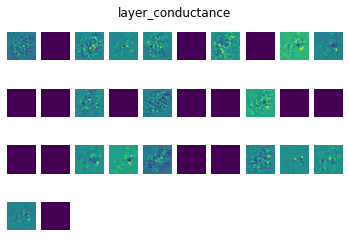

In [8]:
def layer_conductance():
    for img, label in zip(images, labels):
        ##### These should be the only things you need to modify in this code block #####
        module = 'encoder'
        idx = 2
        #################################################################################
        chosen_layer = choose_layer(network, module, idx)
        if verbose:
            print(f"You have chosen {chosen_layer} to show layer conductance")
        layer_conductance_(network, chosen_layer, img, label, None, show_imgs=True, columns=10)

layer_conductance()

## Layer GradxAct

Layer Gradient X Activation is the analog of the Input X Gradient method for hidden layers in a network. It element-wise multiplies the layer's activation with the gradients of the target output with respect to the given layer.

You have chosen Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2)) to show layer conductance


/Users/cynthiachen/Documents/Code/il-representations/src/il_representations/algos/encoders.py:76: UserWarning: Input image tensor values have low stddev 0.0006293190526776016 (range [0.0005074971704743803, 0.003921568859368563]) (stack: runpy.py:193/runpy.py:85/ipykernel_launcher.py:16/application.py:664/kernelapp.py:612/asyncio.py:149/base_events.py:541/base_events.py:1786/events.py:88/ioloop.py:690/ioloop.py:743/gen.py:787/gen.py:748/kernelbase.py:365/gen.py:209/kernelbase.py:268/gen.py:209/kernelbase.py:545/gen.py:209/ipkernel.py:306/zmqshell.py:536/interactiveshell.py:2877/interactiveshell.py:2922/async_helpers.py:68/interactiveshell.py:3146/interactiveshell.py:3337/interactiveshell.py:3417/<ipython-input-9-a2b52ebe2653>:14/<ipython-input-9-a2b52ebe2653>:12/interpret.py:229/layer_gradient_x_activation.py:156/gradient.py:491/gradient.py:238/common.py:503/module.py:550/interpret.py:72/policies.py:511/policies.py:93/module.py:550/policy_interfacing.py:32/module.py:550/encoders.py:288/

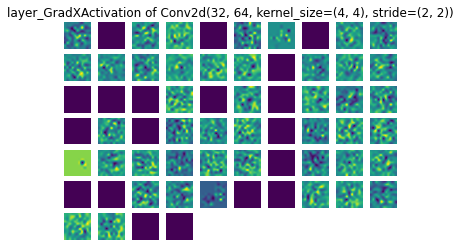

In [9]:
def layer_gradxact():
    for img, label in zip(images, labels):
        ##### These should be the only things you need to modify in this code block #####
        module = 'encoder'
        idx = 2
        #################################################################################
        chosen_layer = choose_layer(network, module, idx)
        if verbose:
            print(f"You have chosen {chosen_layer} to show layer conductance")
    
        layer_act_(network, chosen_layer, LayerGradientXActivation, 'layer_GradXActivation',
                   img, None, show_imgs=True, attr_kwargs={'target': label})

layer_gradxact()

## Layer Activation

Layer Activation is a simple approach for computing layer attribution, returning the activation of each neuron in the identified layer.

You have chosen Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2)) to show layer conductance


/Users/cynthiachen/Documents/Code/il-representations/src/il_representations/algos/encoders.py:76: UserWarning: Input image tensor values have low stddev 0.0006293190526776016 (range [0.0005074971704743803, 0.003921568859368563]) (stack: runpy.py:193/runpy.py:85/ipykernel_launcher.py:16/application.py:664/kernelapp.py:612/asyncio.py:149/base_events.py:541/base_events.py:1786/events.py:88/ioloop.py:690/ioloop.py:743/gen.py:787/gen.py:748/kernelbase.py:365/gen.py:209/kernelbase.py:268/gen.py:209/kernelbase.py:545/gen.py:209/ipkernel.py:306/zmqshell.py:536/interactiveshell.py:2877/interactiveshell.py:2922/async_helpers.py:68/interactiveshell.py:3146/interactiveshell.py:3337/interactiveshell.py:3417/<ipython-input-10-2281cf4c357c>:14/<ipython-input-10-2281cf4c357c>:12/interpret.py:229/layer_activation.py:118/gradient.py:147/gradient.py:361/gradient.py:238/common.py:503/module.py:550/interpret.py:72/policies.py:511/policies.py:93/module.py:550/policy_interfacing.py:32/module.py:550/encoders.

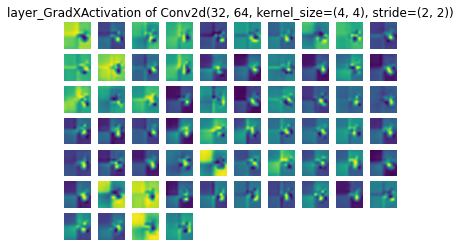

In [10]:
def layer_activation():
    for img, label in zip(images, labels):
        ##### These should be the only things you need to modify in this code block #####
        module = 'encoder'
        idx = 2
        #################################################################################
        chosen_layer = choose_layer(network, module, idx)
        if verbose:
            print(f"You have chosen {chosen_layer} to show layer conductance")
    
        layer_act_(network, chosen_layer, LayerActivation, 'layer_GradXActivation',
                   img, None, show_imgs=True, attr_kwargs={})

layer_activation()